## 配对和BLS数字签名-简介
BLS字母代表Boneh–Lynn–Shacham，最初是由斯坦福大学教授Dan Boneh等人于2001年提出的一种签名方案，最新是在2018年，Boneh教授与IBM研究机构的Manu Drijvers等人更新了这种签名方案。与以往介绍的签名方案不同的是，BLS采用了基于双线性映射的椭圆曲线配对技术，来实现签名验证与聚合。

### BLS签名过程
BLS签名需要用到两个新的结构：哈希到曲线（hashing to the curve）以及曲线配对 (curve pairing). 哈希到椭圆曲线，最简单的方法是先对消息进行Hash，并将结果当作曲线点的 x 坐标，但这个点有可能不在曲线上，所以一般要做一些尝试以找出符合曲线要求的点x坐标，例如对hash再和1,2,3这样的消息哈希（有点像比特币POW挖矿不断尝试nonce值），还有一种方案是接将hash结果乘以G（循环子群的生成元），这样肯定能得到一个点。在ECElgamal加密的时候也会有类似的问题，解决办法也基本类同。

#### 准备阶段
秘密选取随机数字作为私钥pk，计算公钥$P = pk × G$，待签名的消息m。

#### 签名
将消息哈希H(m)映射到曲线上的点,记为Q
将结果点乘以私钥得到签名: $ S = pk × Q $ 

#### 验证签名
检验 $e(P, Q) = e(G, S)$
函数e就是所谓的曲线配对函数

### 曲线配对函数
有一个（或一种）特殊的函数记为e，它可以接受输入一条（或两条不同）曲线上两点P和Q，输出至一个数字，如下式：

$e(P, Q) → n$

之所以说这个函数特殊，是因为它有一些特殊性质。例如我们有一个数x和两点P和Q，无论哪一个点乘以这个数字，函数结果相同即：
$e(x * P, Q) = e(P, x * Q)$
更进一步：
$e(a * P, b * Q) = e(P, ab * Q) = e(ab * P, Q) = e(P, Q)^{ab} $

当然还有其他性质，但是对于我们用来验证签名，主要用到以上性质。

要验证签名：
$ e(P, Q) = e(pk * G, Q) = e (pk * G, Q) = e (G, pk * Q) = e (G, S)$

### BLS签名的特点
没有随机数，没有额外的操作，只有哈希乘以私钥！我们的签名只是曲线上的一个单点，在压缩序列化格式中只需要 33 个字节！
相比schnorr、ECDSA等算法，具有以下特点：
* 时间缩短 2 倍
* 对签名和密钥聚合友好
* 具有确定性：它不依赖于随机数生成器。
由于其最小的存储和带宽要求它已被以太坊、Dfinity、Algorand 和 Chia 等多个区块链采用。

### BLS签名的缺点
精心选择的配对函数，它可能是 BLS 签名方案最大的缺陷。BLS 签名的配对是很难的，我们认为神奇的函数  $e(P, Q)$ 是有效和安全的，但事实并非如此。BLS 签名验证要比 ECDSA 签名验证的难度大上几个数量级。对于具有 1000 笔交易的整个区块的签名聚合，仍然需要计算 1000 次配对，因此验证一个区块中的一个小签名，可能比验证 1000 个单独的 ECDSA 签名需要更长的时间。我们需要非常小心地选择对配对友好的曲线。

实际上有一种针对椭圆曲线加密系统的攻击方法称为 MOV 攻击（以Menezes, Okamoto和Vanstone命名），它允许使用我们的魔法配对函数来降低系统的安全性。


#### BLS签名的几何意义
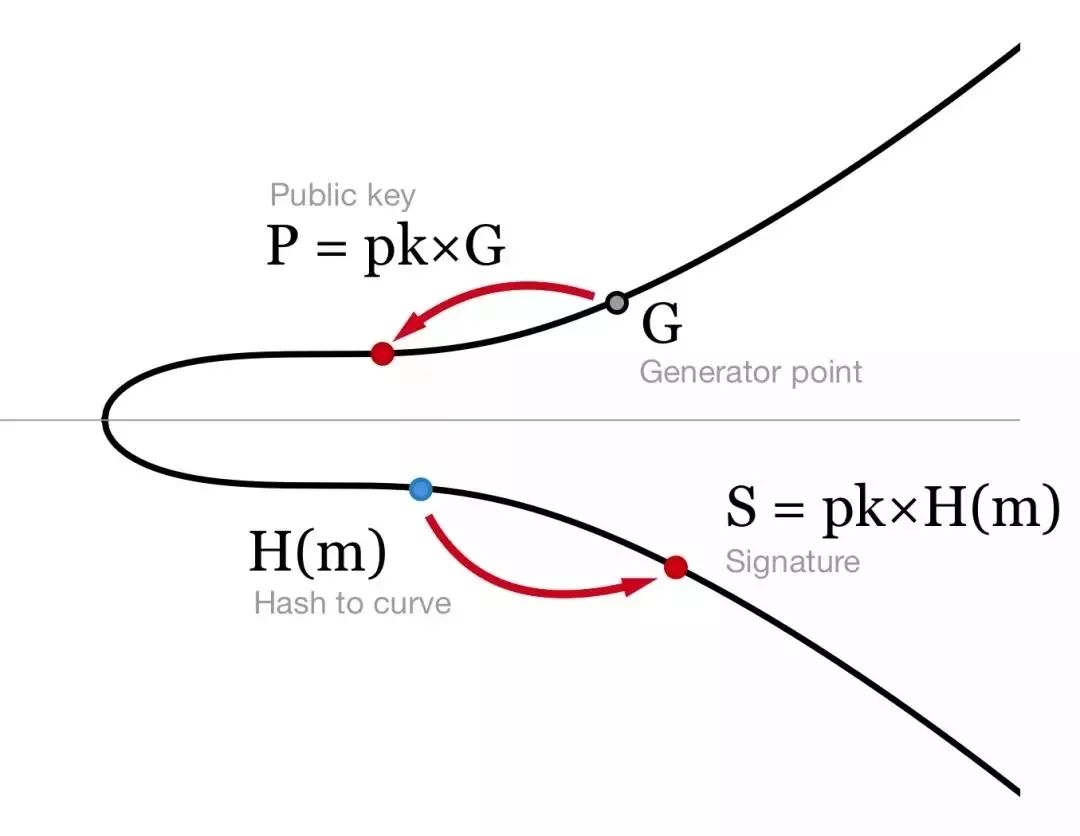

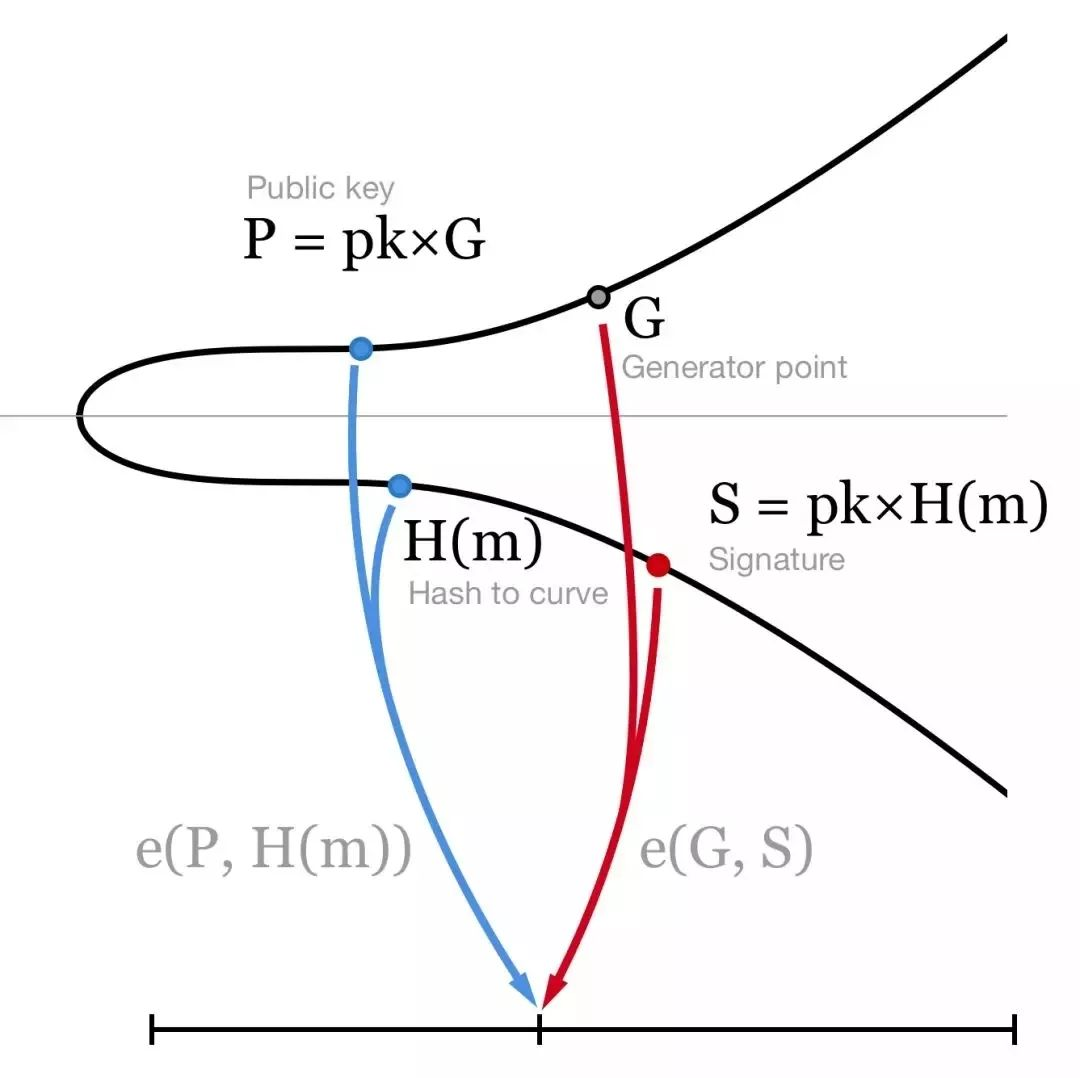

### BLS聚合签名

假设我们有一个包含 1000 笔交易的区块，每笔交易都包含一个签名 $S_i$、一个公钥 $P_i$ 以及一个签名为 $m_i$ 的消息。如果我们可以合并所有签名，为什么要存储所有的签名？毕竟，我们只关心区块中的所有签名是否有效。聚合签名将只是区块中所有签名的总和： $ S = S_1+S_2+…+S_{1000}$ 要验证区块，我们需要检查以下等式是否成立：

$ e(G, S) = e(P_1, H(m_1))⋅e(P_2, H(m_2))⋅…⋅e(P_{1000}, H(m_{1000}))$ 

如果你仔细看，你会发现这是真的：

$ e(G, S) = e(G, S_1+S_2+…+S_{1000}) = e(G, S_1)⋅e(G, S_2)⋅…⋅e(G, S_{1000}) = e(G, pk_1×H(m_1))⋅…⋅e(G, pk_{1000}×H(m_{1000})) = e(pk_1×G, H(m_1))⋅…⋅e(pk_{1000}×G, H(m_{1000})) = e(P_1, H(m_1))⋅e(P_2, H(m_2))⋅…⋅e(P_{1000}, H(m_{1000}))$

我们仍然需要知道所有的公钥并计算 1001 个配对函数，但是至少区块中的所有签名只占用 33 个字节。签名聚合可以由矿工完成，并节省区块大量的空间。

### BLS m-n多签
通常我们不会想用 n-of-n 的多重签名方案，我们更喜欢使用 m-of-n（比如说2-of-3） 的多重签名方案，我们不想丢了一把私钥就把钱给弄丢。在这种情况下，最好使用密钥聚合。有了 Schnorr 签名方案，我们就可以通过使用公共密钥的默克尔树来做到这一点，它不是最有效的办法，但很管用，坏处在于一旦 m 和 n 值很大，默克尔树（merkle tree）的大小就会成倍放大。

而对于 BLS 签名方案，还有另一种方法。不过也没那么简单，我们需要一个普通的哈希函数，它输出一个数字 hash(x)，以及一个到曲线的哈希  H(x)。当我们决定使用多重签名时，我们还需要一个“设置”阶段，但在此之后，我们不再需要通信，我们只需要签名来签署任何数量的交易。

例如我们希望构建三个不同设备上存储密钥的 2-of-3 多重签名方案，但它可以扩展到任何值的 m 和 n。

#### 设置阶段

我们的每个设备都有一个签名者编号 i=1,2,3，代表其在集合中的位置，一个私钥 $pk_i$ 以及一个对应的公钥 $P_i = pk_i×G$。这里计算聚合公钥的方式与之前完全相同：

$P = a_1×P_1+a_2×P_2+a_3×P_3, \\
a_i = hash(P_i, {P1,P2,P3}) $

现在，每个设备都需要签名，而编号i是我们的聚合公钥的成员（对于每个 i），聚合这些签名并将结果保存到相应的设备上：

$MK_i = (a_1⋅pk_1)×H(P, i)+(a_2⋅pk_2)×H(P, i)+(a_3⋅pk_3)×H(P, i)$

这个签名我们称为“成员密钥”，稍后我们将使用它进行签名。每个成员密钥都是消息 $H(P,i)$ 的有效 n-of-n 签名，这意味着：

$e(G, MK_i)=e(P, H(P,i))$

它将用来证明我们是多重签名方案的有效参与者。

#### 签名

现在假设我们只想用密钥 $pk_1$ 和 $pk_3$ 签署一笔交易。我们生成两个签名 $S_1$ 和 $S_3$: <br>
$S_1 = pk_1×H(P, m)+MK_1, \\
S_3=pk_3×H(P, _m)+MK_3$ <br>
并将它们相加以获得单个签名和密钥：

$(S’, P’) = (S_1+S_3, P_1+P_3)$

我在这里写为 P’和 S’，来强调这个密钥和签名只由签名者的一个子集签名，它与 P 不同，P 是所有签名者的聚合密钥。要验证这 3 个签名中的 2 个，我们需要检查：

$ e(G, S’) = e(P’, H(P, m))⋅e(P, H(P, 1)+H(P, 3))$

我们记得成员密钥 $MK_1$ 和 $MK_3$ 是由聚合密钥 P 签名的消息 $H(P, 1)$ 及 $H(P, 3)$ 的有效签名，因此：

$e(G, S’) = e(G, S_1+S_3)=e(G, pk_1×H(P, m)+pk_3×H(P, m)+MK_1+MK_3) =e(G, pk_1×H(P, m)+pk_3×H(P, m))⋅e(G, MK_1+MK_3)=e(pk_1×G+pk_3×G, H(P, m))⋅e(P, H(P, 1)+H(P, 3))=e(P’, H(P, m))⋅e(P, H(P, 1)+H(P, 3)) $

比 n-of-n 复杂很多。

### BLS签名可能的应用场景
要实现这个多重签名方案，我们需要将资金发送到与聚合公钥 P 对应的地址，并表示我们至少需两个签名。在比特币脚本语言中，锁定脚本可能如下所示：

OP_2OP_CHECK_BLS_MULTISIG

这里，OP_2 告诉我们需要两个密钥来签署消息。我们不会说任何地方总共就只有 3 个签名者，所以不能说它是 2-of-3 还是 2-of-100 多重签名地址。为了使用这个输出，我们需要在我们的案例 1 和 3 中提供参与签名者的密钥 P’、签名 S’以及索引。

解锁脚本可能如下所示：

OP_1 OP_3 <P’> <S’>

结合这些脚本，可以给我们提供所有必要的信息。从 OP_1 和 OP_3，我们知道我们需要计算哈希 H(P, 1) 和 H(P, 3)，然后我们就拥有了验证交易所需的一切。这意味着对于任何 m 和 n，我们只需要：

1. 锁定脚本中的一个聚合公钥 P；

2. 参与签名者的一个聚合公钥 P’

3. 一个聚合签名；

4. 带有签名者索引的 m 数字；
